In [5]:
import pandas as pd
import glob
from google.colab import drive
drive.mount('/content/drive')
# Define the path to the folder containing the data files
data_folder_path = "/content/drive/MyDrive/training_data/order_data/"
cluster_map_path = "/content/drive/MyDrive/training_data/cluster_map/cluster_map"

# Use glob to find all the order data files in the directory
order_data_files = glob.glob(data_folder_path + "*")
# Ensure there are files to read
if order_data_files:
    # Load all order data files, assuming they are tab-separated
    order_data_list = [pd.read_csv(f, header=None, sep='\t') for f in order_data_files]
    # Concatenate all data into a single DataFrame
    order_data = pd.concat(order_data_list, ignore_index=True)
    # Define column names for the order data
    order_data.columns = [
        "order_id",
        "driver_id",
        "passenger_id",
        "start_region_hash",
        "dest_region_hash",
        "Price",
        "Time",
    ]
    # Convert 'Time' to datetime and extract the day
    order_data['Time'] = pd.to_datetime(order_data['Time'])
    order_data['day'] = order_data['Time'].dt.day
else:
    raise FileNotFoundError("No order data files found in the directory.")

# Load cluster map data, assuming it is tab-separated
cluster_map_data = pd.read_csv(cluster_map_path, header=None, sep='\t')
cluster_map_data.columns = ["region_hash", "region_id"]

# Merge cluster map with order data to get the region ID for each order
order_data_merged = order_data.merge(cluster_map_data, how='left', left_on='start_region_hash', right_on='region_hash')

# Display the first few rows of the combined DataFrame
print(order_data_merged.head())

# The 'order_data_merged' DataFrame now contains order data with datetime and corresponding region IDs.
# You can save this DataFrame to a CSV file or proceed with further data processing as needed.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                           order_id                         driver_id  \
0  97ebd0c6680f7c0535dbfdead6e51b4b  dd65fa250fca2833a3a8c16d2cf0457c   
1  92c3ac9251cc9b5aab90b114a1e363be  c077e0297639edcb1df6189e8cda2c3d   
2  abeefc3e2aec952468e2fd42a1649640  86dbc1b68de435957c61b5a523854b69   
3  cb31d0be64cda3cc66b46617bf49a05c  4fadfa6eeaa694742de036dddf02b0c4   
4  139d492189ae5a933122c098f63252b3                               NaN   

                       passenger_id                 start_region_hash  \
0  ed180d7daf639d936f1aeae4f7fb482f  4725c39a5e5f4c188d382da3910b3f3f   
1  191a180f0a262aff3267775c4fac8972  82cc4851f9e4faa4e54309f8bb73fd7c   
2  7029e813bb3de8cc73a8615e2785070c  fff4e8465d1e12621bc361276b6217cf   
3  21dc133ac68e4c07803d1c2f48988a83  4b7f6f4e2bf237b6cc58f57142bea5c0   
4  26963cc76da2d8450d8f23fc357db987  fc34648599753c9e74ab238e9a4a07

In [6]:
import pandas as pd

# Assuming 'order_data_merged' is your DataFrame after merging order data with cluster data

# Helper function to convert timestamps to day number and 10-minute bins
def get_day_number_and_time_slot(time):
    # Get day number (1-indexed)
    day_number = time.day
    # Convert time to minutes since midnight
    minutes_since_midnight = time.hour * 60 + time.minute
    # Divide by 10 to get the slot number, add 1 to start slot count at 1
    time_slot = (minutes_since_midnight // 10) + 1
    return day_number, time_slot

# Apply the helper function to the 'Time' column
order_data_merged[['day_number', 'time_slot']] = order_data_merged.apply(lambda row: get_day_number_and_time_slot(row['Time']), axis=1, result_type='expand')

# Calculate demand and supply
# Demand: Count of orders per region per day number per time slot
# Supply: Count of fulfilled orders (where driver_id is not null) per region per day number per time slot
# Group by region_id, day_number, and time_slot to get these counts

# Calculate demand
demand = order_data_merged.groupby(['region_id', 'day_number', 'time_slot']).size().reset_index(name='demand')

# Calculate supply
supply = order_data_merged[order_data_merged['driver_id'].notnull()].groupby(['region_id', 'day_number', 'time_slot']).size().reset_index(name='supply')

# Merge demand and supply on region_id, day_number, and time_slot
demand_supply = demand.merge(supply, on=['region_id', 'day_number', 'time_slot'], how='left')

# Replace NaN supply values with 0 (no drivers for these requests)
demand_supply['supply'] = demand_supply['supply'].fillna(0).astype(int)

# Calculate the gap
demand_supply['gap'] = demand_supply['demand'] - demand_supply['supply']

# Final DataFrame with demand, supply, and gap
final_df = demand_supply[['region_id', 'day_number', 'time_slot', 'demand', 'supply', 'gap']]

# Display the final DataFrame
print(final_df.head())

# You can now save this DataFrame to a CSV or use it for further analysis


   region_id  day_number  time_slot  demand  supply  gap
0          1           1          1     187     178    9
1          1           1          2     198     191    7
2          1           1          3     192     182   10
3          1           1          4     172     167    5
4          1           1          5     153     152    1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the data
X = final_df[['region_id', 'day_number', 'time_slot']]  # Features
y = final_df['gap']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the accuracy score and RMSE
accuracy_score = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display the results
print(f"Accuracy Score: {accuracy_score}")
print(f"RMSE: {rmse}")


Accuracy Score: 0.0005478037494272003
RMSE: 54.56313456738346


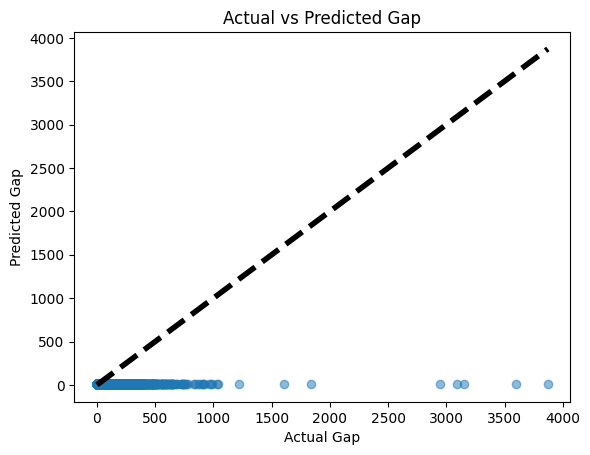

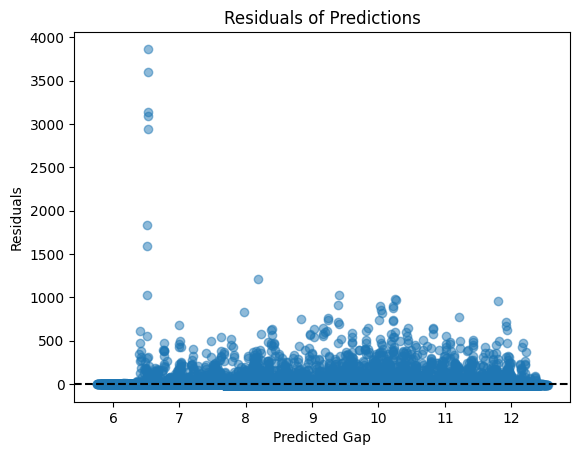

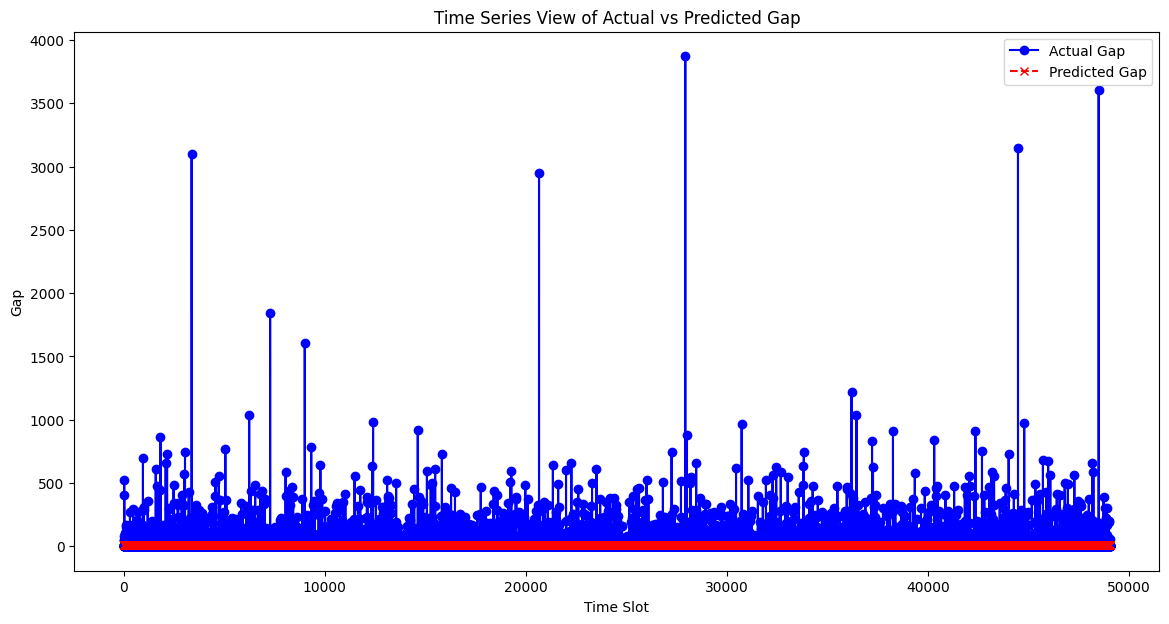

In [8]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Gap')
plt.ylabel('Predicted Gap')
plt.title('Actual vs Predicted Gap')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.show()

# Plotting residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Gap')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

# Plotting predictions over time (if the time_slot can be treated as a continuous sequence)
# This part assumes your 'time_slot' is a continuous sequence, like hours of the day.
plt.figure(figsize=(14, 7))
time_range = range(len(y_test))  # Just a range for x-axis
plt.plot(time_range, y_test, label='Actual Gap', color='blue', marker='o')
plt.plot(time_range, y_pred, label='Predicted Gap', color='red', linestyle='--', marker='x')
plt.xlabel('Time Slot')
plt.ylabel('Gap')
plt.title('Time Series View of Actual vs Predicted Gap')
plt.legend()
plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the data
X = final_df[['region_id', 'day_number', 'time_slot']].values  # Features
y = final_df['gap'].values  # Target

# Convert 'region_id' to numeric if it's categorical, as KNN requires all inputs to be numeric
# If 'region_id' is categorical, this step is necessary. Otherwise, remove this step.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN regression model
# n_neighbors is a parameter you can tune. Starting with 5 as a default
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R-squared value as the 'accuracy score'
r_squared = knn_model.score(X_test, y_test)

# Display the results
print(f"R-squared Value: {r_squared}")
print(f"RMSE: {rmse}")


R-squared Value: 0.5993399492221101
RMSE: 33.51804334900637


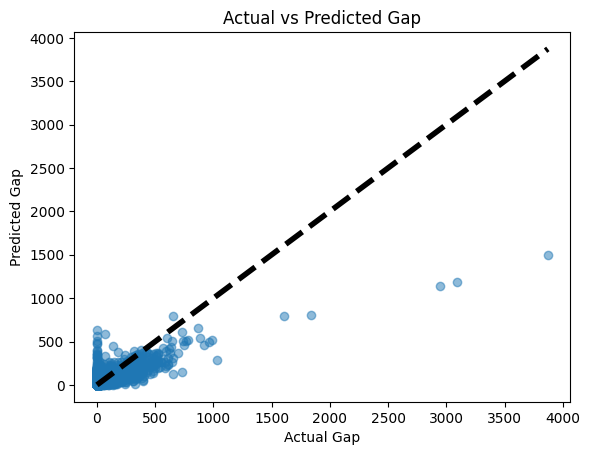

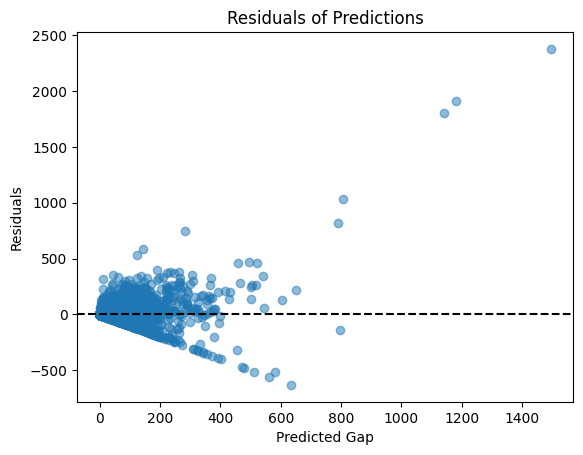

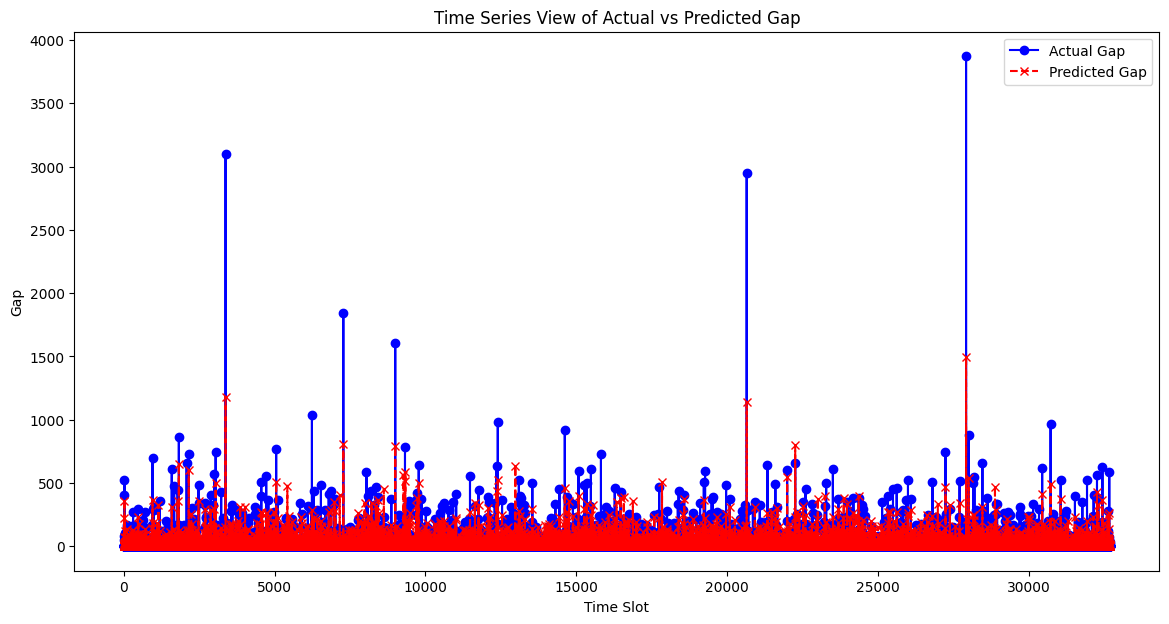

In [10]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Gap')
plt.ylabel('Predicted Gap')
plt.title('Actual vs Predicted Gap')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.show()

# Plotting residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Gap')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

# Plotting predictions over time (if the time_slot can be treated as a continuous sequence)
plt.figure(figsize=(14, 7))
time_range = range(len(y_test))  # Just a range for x-axis
plt.plot(time_range, y_test, label='Actual Gap', color='blue', marker='o')
plt.plot(time_range, y_pred, label='Predicted Gap', color='red', linestyle='--', marker='x')
plt.xlabel('Time Slot')
plt.ylabel('Gap')
plt.title('Time Series View of Actual vs Predicted Gap')
plt.legend()
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the data
X = final_df[['region_id', 'day_number', 'time_slot']].values  # Features
y = final_df['gap'].values  # Target

# If 'region_id' is categorical, it needs to be converted to numeric. Otherwise, this step can be skipped.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest regression model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Make predictions
y_pred = random_forest_model.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R-squared value
r_squared = random_forest_model.score(X_test, y_test)

# Display the results
print(f"R-squared Value: {r_squared}")
print(f"RMSE: {rmse}")


R-squared Value: 0.9278693160272794
RMSE: 14.221672147519048


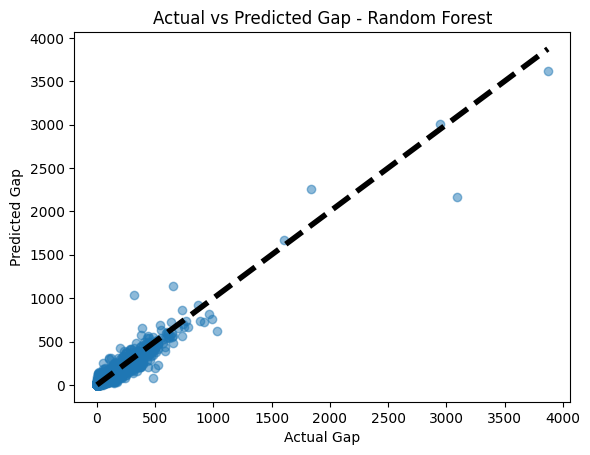

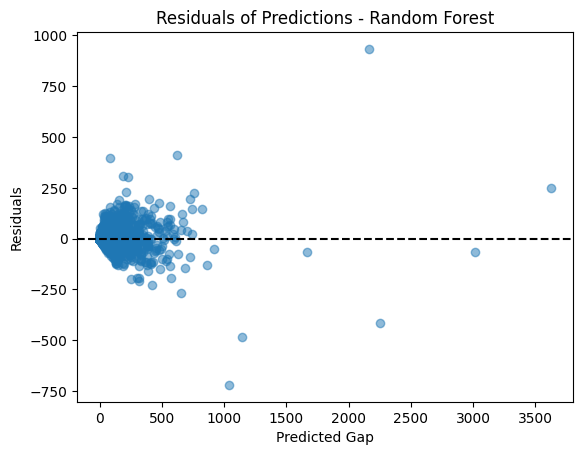

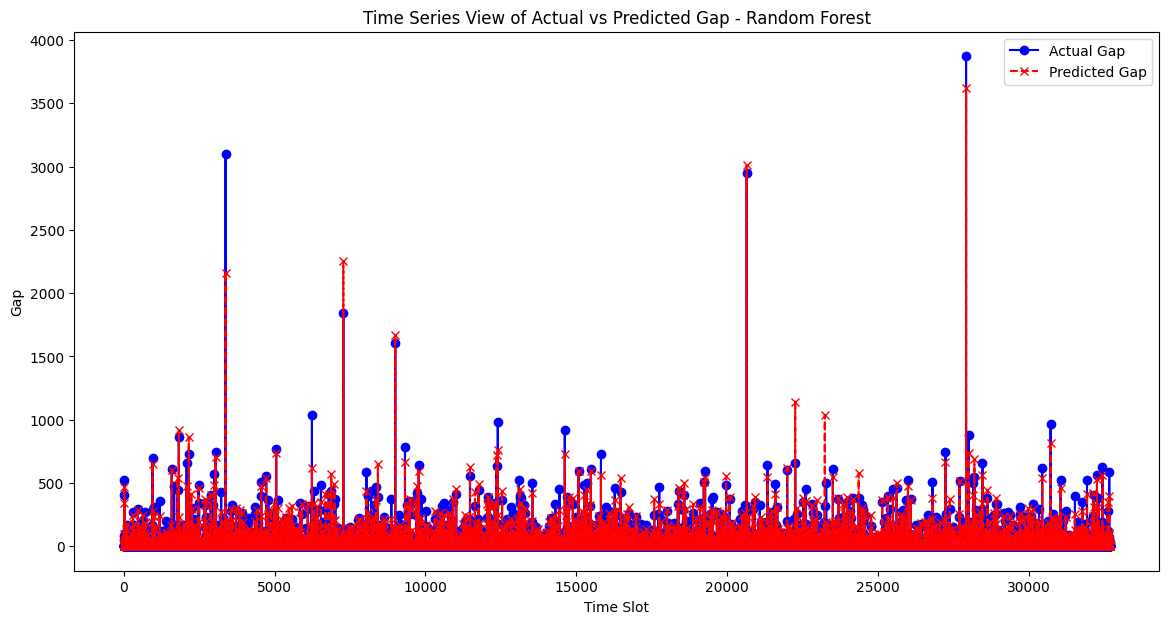

In [12]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Gap')
plt.ylabel('Predicted Gap')
plt.title('Actual vs Predicted Gap - Random Forest')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.show()

# Plotting residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Gap')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions - Random Forest')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

# Plotting predictions over time (if the time_slot can be treated as a continuous sequence)
plt.figure(figsize=(14, 7))
time_range = range(len(y_test))  # Just a range for x-axis
plt.plot(time_range, y_test, label='Actual Gap', color='blue', marker='o')
plt.plot(time_range, y_pred, label='Predicted Gap', color='red', linestyle='--', marker='x')
plt.xlabel('Time Slot')
plt.ylabel('Gap')
plt.title('Time Series View of Actual vs Predicted Gap - Random Forest')
plt.legend()
plt.show()


In [13]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize the Lasso regression model
lasso_model = Lasso(alpha=0.1, random_state=42)  # alpha is a hyperparameter you can tune

# Train the model
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Calculate the RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# Calculate the R-squared value
r_squared_lasso = lasso_model.score(X_test, y_test)

# Display the results for Lasso Regression
print(f"Lasso Regression - R-squared Value: {r_squared_lasso}")
print(f"Lasso Regression - RMSE: {rmse_lasso}")


Lasso Regression - R-squared Value: 0.000786277562049964
Lasso Regression - RMSE: 52.93218628828998


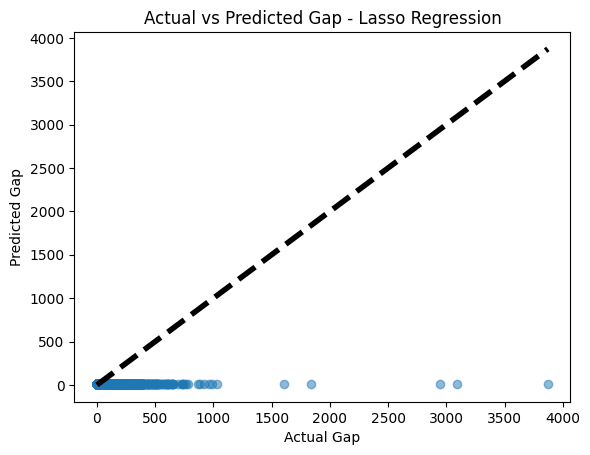

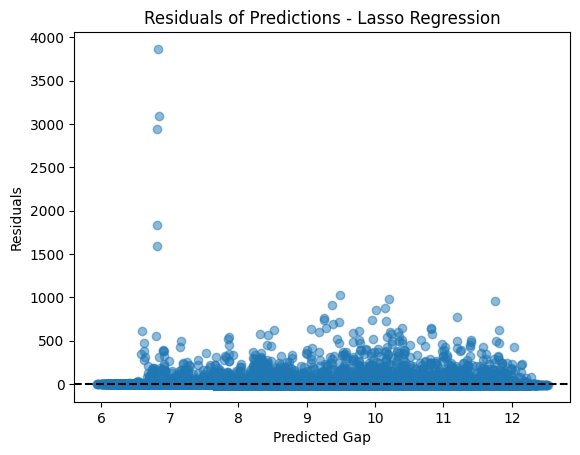

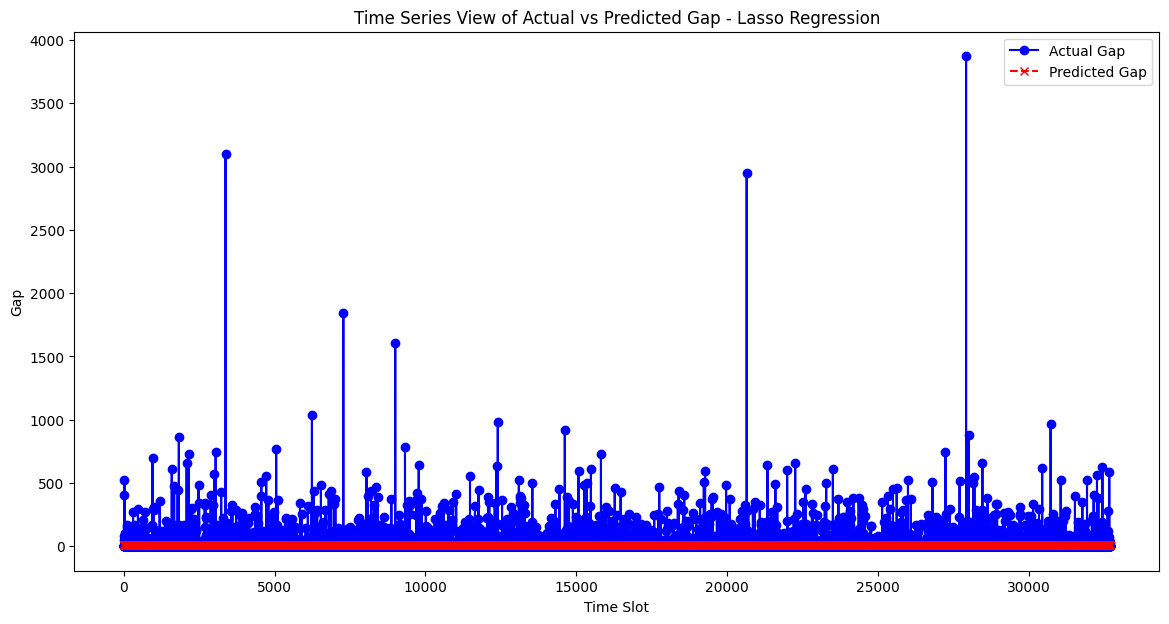

In [14]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel('Actual Gap')
plt.ylabel('Predicted Gap')
plt.title('Actual vs Predicted Gap - Lasso Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.show()

# Plotting residuals
residuals_lasso = y_test - y_pred_lasso
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
plt.xlabel('Predicted Gap')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions - Lasso Regression')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

# Plotting predictions over time (if the time_slot can be treated as a continuous sequence)
plt.figure(figsize=(14, 7))
time_range = range(len(y_test))  # Just a range for x-axis
plt.plot(time_range, y_test, label='Actual Gap', color='blue', marker='o')
plt.plot(time_range, y_pred_lasso, label='Predicted Gap', color='red', linestyle='--', marker='x')
plt.xlabel('Time Slot')
plt.ylabel('Gap')
plt.title('Time Series View of Actual vs Predicted Gap - Lasso Regression')
plt.legend()
plt.show()


In [15]:
from sklearn.linear_model import Ridge

# Initialize the Ridge regression model
ridge_model = Ridge(alpha=1, random_state=42)  # alpha is a hyperparameter you can tune

# Train the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Calculate the RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# Calculate the R-squared value
r_squared_ridge = ridge_model.score(X_test, y_test)

# Display the results for Ridge Regression
print(f"Ridge Regression - R-squared Value: {r_squared_ridge}")
print(f"Ridge Regression - RMSE: {rmse_ridge}")


Ridge Regression - R-squared Value: 0.0007871914482450171
Ridge Regression - RMSE: 52.93216208225462


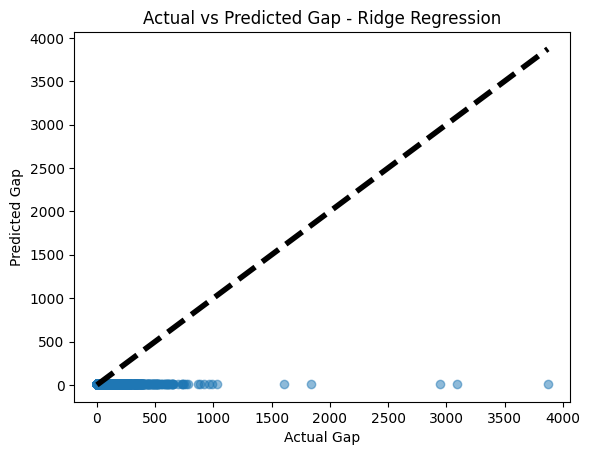

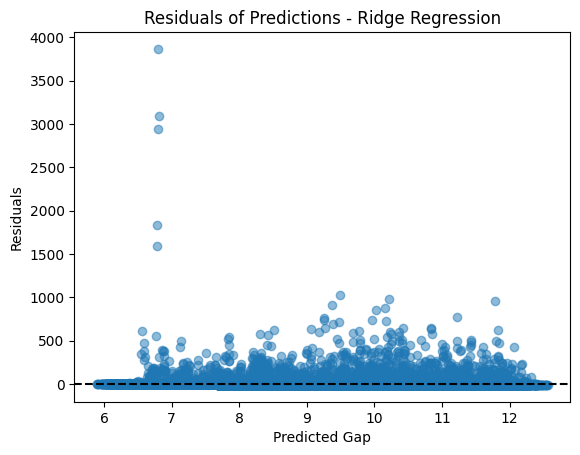

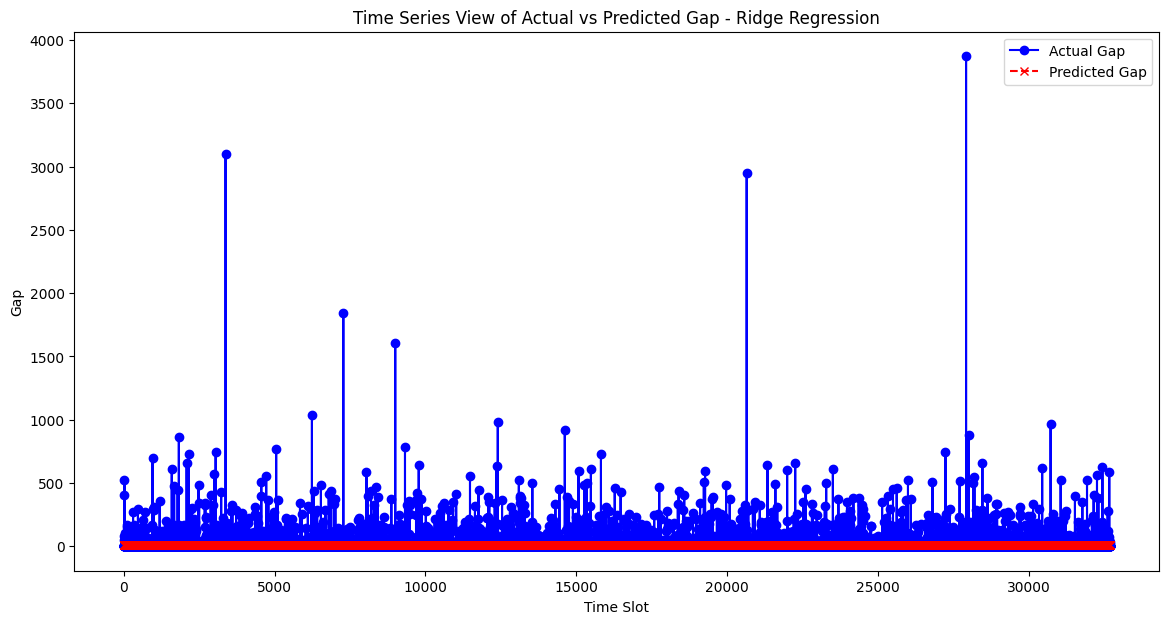

In [16]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.xlabel('Actual Gap')
plt.ylabel('Predicted Gap')
plt.title('Actual vs Predicted Gap - Ridge Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.show()

# Plotting residuals
residuals_ridge = y_test - y_pred_ridge
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5)
plt.xlabel('Predicted Gap')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions - Ridge Regression')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

# Plotting predictions over time (if the time_slot can be treated as a continuous sequence)
plt.figure(figsize=(14, 7))
time_range = range(len(y_test))  # Just a range for x-axis
plt.plot(time_range, y_test, label='Actual Gap', color='blue', marker='o')
plt.plot(time_range, y_pred_ridge, label='Predicted Gap', color='red', linestyle='--', marker='x')
plt.xlabel('Time Slot')
plt.ylabel('Gap')
plt.title('Time Series View of Actual vs Predicted Gap - Ridge Regression')
plt.legend()
plt.show()


In [17]:
import matplotlib.pyplot as plt

# Assume 'final_df' is your existing DataFrame and 'random_forest_model' is the trained model
# Duplicate the last week's data and shift the day numbers forward by 7
future_df = final_df[final_df['day_number'].between(15, 21)].copy()
future_df['day_number'] += 7

# We won't have future 'demand' and 'supply', so let's assume they are similar to the last week
# If you have better estimates or methods to predict demand and supply, use those instead

# Prepare the features for the model
X_future = future_df[['region_id', 'day_number', 'time_slot']].values

# Predict the gap using the selected model
future_df['predicted_gap'] = random_forest_model.predict(X_future)

future_df


,region_id,day_number,time_slot,demand,supply,gap,predicted_gap
2016,1,22,1,77,73,4,1.73
2017,1,22,2,57,50,7,1.87
2018,1,22,3,68,61,7,1.14
2019,1,22,4,53,53,0,1.06
2020,1,22,5,39,38,1,0.24
...,...,...,...,...,...,...,...
163486,66,28,140,5,5,0,0.38
163487,66,28,141,4,4,0,0.07
163488,66,28,142,6,6,0,0.08
163489,66,28,143,7,6,1,0.57


<ipython-input-19-e12ae5f9c5b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_data['continuous_time_slot'] = (original_data['day_number'] - 15) * 144 + original_data['time_slot']


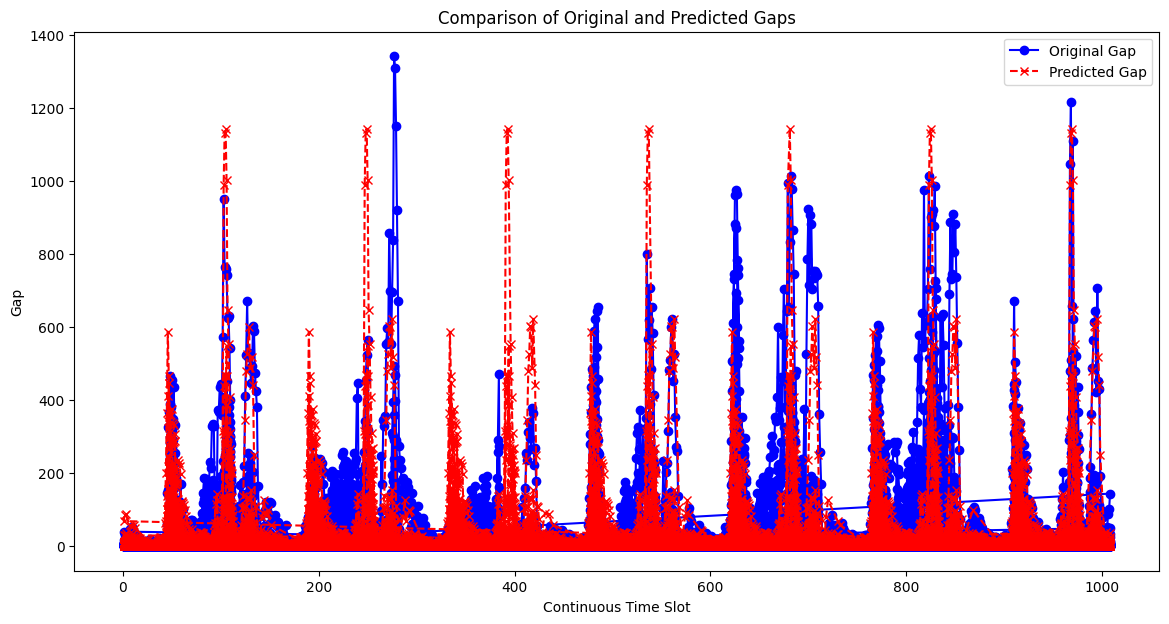

In [19]:
import matplotlib.pyplot as plt

# Plotting original gaps
plt.figure(figsize=(14, 7))

# Filter original data to match the time period for comparison
original_data = final_df[final_df['day_number'].between(15, 21)]
# Calculating a continuous time slot across days for plotting
original_data['continuous_time_slot'] = (original_data['day_number'] - 15) * 144 + original_data['time_slot']

# Plotting original gaps
plt.plot(original_data['continuous_time_slot'], original_data['gap'], label='Original Gap', color='blue', marker='o')

# Preparing future data for plotting
future_df['continuous_time_slot'] = (future_df['day_number'] - 22) * 144 + future_df['time_slot']
# Plotting predicted gaps
plt.plot(future_df['continuous_time_slot'], future_df['predicted_gap'], label='Predicted Gap', color='red', linestyle='--', marker='x')

plt.xlabel('Continuous Time Slot')
plt.ylabel('Gap')
plt.title('Comparison of Original and Predicted Gaps')
plt.legend()
plt.show()
